## 导入模块

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
from collections import Counter
from scipy.stats import pearsonr
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
import sklearn
import scipy
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

## 数据预处理

In [5]:
data = pd.read_csv('data_model.csv')
variable = pd.read_excel('变量说明表.xlsx')
data_train = data.iloc[:,:-1]
data_target = data.iloc[:,-1:]
target = [x[0] for x in data_target.values]

index = np.where(variable.iloc[2:,6] > 0.5)   # 原始数据缺失率超过50%的数据的index
Drop_features = data_train.columns.values[index]
data_train = data_train.drop(Drop_features,axis=1)

le = LabelEncoder()
enc = OneHotEncoder(sparse=False)

for feature in ['custr_EDUCA','bill_num_curver','bill_amt_curver']:  # 需要进行整数编码的特征
    data_train[feature] = le.fit_transform(data_train[feature])   
    
for feature in ['custr_organ','custr_gender','custr_MAR_STATUS','xaccount_addr_type','xaccount_ifautopay','xaccount_CON_REL']:
# for feature in ['custr_organ']:
    # 需要进行One-Hot编码的特征
    a = le.fit_transform(data_train[feature])
    b = enc.fit_transform(a.reshape(-1,1))
    columns = []
    for i in range(b.shape[1]):
        columns.append(feature+'_'+str(i))
    df = pd.DataFrame(b,columns=columns)  # One-Hot编码的同时保留列的名称
    data_train = pd.concat([data_train,df],axis=1)
    data_train = data_train.drop([feature],axis=1)
    
scaler = MinMaxScaler()
data_train = pd.DataFrame(scaler.fit_transform(data_train),columns=data_train.columns)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_train, target, test_size=0.3, random_state=42)

## 建立模型

### 逻辑回归分类器

In [7]:
def logistic_regression_classifier(train_x, train_y):  
    from sklearn.linear_model import LogisticRegression  
    model = LogisticRegression(penalty='l2')  
    model.fit(train_x, train_y)  
    return model  

### 朴素贝叶斯分类器

In [8]:
def naive_bayes_classifier(train_x, train_y):  
    from sklearn.naive_bayes import MultinomialNB  
    model = MultinomialNB(alpha=0.01)  
    model.fit(train_x, train_y)  
    return model 

### 自由森林分类器

In [9]:
def random_forest_classifier(train_x, train_y):  
    from sklearn.ensemble import RandomForestClassifier  
    model = RandomForestClassifier(n_estimators=8)  
    model.fit(train_x, train_y)  
    return model 

### 决策树分类器

In [10]:
 def decision_tree_classifier(train_x, train_y):  
    from sklearn import tree  
    model = tree.DecisionTreeClassifier()  
    model.fit(train_x, train_y)  
    return model 

### GBDT分类器

In [11]:
def gradient_boosting_classifier(train_x, train_y):  
    from sklearn.ensemble import GradientBoostingClassifier  
    model = GradientBoostingClassifier(n_estimators=200)  
    model.fit(train_x, train_y)  
    return model 

### SVM分类器

In [12]:
def svm_classifier(train_x, train_y):  
    from sklearn.svm import SVC  
    model = SVC(kernel='rbf', probability=True)  
    model.fit(train_x, train_y)  


### 带交叉验证的SVM分类器

In [13]:
def svm_cross_validation(train_x, train_y):  
    from sklearn.grid_search import GridSearchCV  
    from sklearn.svm import SVC  
    model = SVC(kernel='rbf', probability=True)  
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}  
    grid_search = GridSearchCV(model, param_grid, n_jobs = 1, verbose=1)  
    grid_search.fit(train_x, train_y)  
    best_parameters = grid_search.best_estimator_.get_params()  
    for para, val in list(best_parameters.items()):  
        print(para, val)  
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)  
    model.fit(train_x, train_y)  
    return model 

### XGB分类器

In [14]:
 def XGBoost_classifier(train_x, train_y):  
    import xgboost as xgb 
    model = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_x, train_y) 
    return model 

### Catboost分类器

In [15]:
def CatBoost_classifier(train_x, train_y):  
    from catboost import CatBoostClassifier
    model=CatBoostClassifier(iterations=2,depth=2,learning_rate=1,loss_function='Logloss', logging_level='Verbose').fit(train_x, train_y)
    return model 

## 评估模型

In [16]:
def scores_of_model(model,y_train,y_test):
    y_pred_class = model.predict(y_train)
    print(y_pred_class)
    print('混淆矩阵：',metrics.confusion_matrix(y_test, y_pred_class))
    print('分类准确率：',metrics.accuracy_score(y_test, y_pred_class))
    print('分类召回率：',metrics.recall_score(y_test, y_pred_class))
    print('f1-score：',metrics.f1_score(y_test, y_pred_class))
    
    return y_pred_class

In [17]:
model_logistic = logistic_regression_classifier(X_train,y_train)
print('model Logistic')
y_score_logistic = scores_of_model(model_logistic,X_test,y_test)

model Logistic
[0 0 0 ... 0 0 0]
混淆矩阵： [[43156    45]
 [ 1082   141]]
分类准确率： 0.9746308301818837
分类召回率： 0.11529026982829109
f1-score： 0.2001419446415898


In [18]:
model_bayes = naive_bayes_classifier(X_train,y_train)
print('model Bayes')
y_score_bayes = scores_of_model(model_bayes,X_test,y_test)

model Bayes
[0 0 0 ... 0 0 1]
混淆矩阵： [[40624  2577]
 [  979   244]]
分类准确率： 0.9199531784620926
分类召回率： 0.19950940310711365
f1-score： 0.12067260138476756


In [19]:
model_random_forest = random_forest_classifier(X_train,y_train)
print('model Random forest')
y_score_random_forest = scores_of_model(model_random_forest,X_test,y_test)

model Random forest
[0 0 0 ... 0 0 0]
混淆矩阵： [[43158    43]
 [  790   433]]
分类准确率： 0.9812488744822618
分类召回率： 0.35404742436631237
f1-score： 0.5097115950559152


In [20]:
model_decision_tree = decision_tree_classifier(X_train,y_train)
print('model Decision tree')
y_score_decision_tree = scores_of_model(model_decision_tree,X_test,y_test)

model Decision tree
[0 0 0 ... 0 0 0]
混淆矩阵： [[42562   639]
 [  536   687]]
分类准确率： 0.9735503331532505
分类召回率： 0.5617334423548651
f1-score： 0.5390349156531974


In [21]:
model_gradient_boosting = gradient_boosting_classifier(X_train,y_train)
print('model Gradient boosting')
y_score_gradient_boosting = scores_of_model(model_gradient_boosting,X_test,y_test)

model Gradient boosting
[0 0 0 ... 0 0 0]
混淆矩阵： [[43124    77]
 [  563   660]]
分类准确率： 0.9855933729515577
分类召回率： 0.5396565821749796
f1-score： 0.6734693877551021


In [22]:
model_XGB = XGBoost_classifier(X_train,y_train)
print('model XGB')
y_score_XGB = scores_of_model(model_XGB,X_test,y_test)

model XGB
[0 0 0 ... 0 0 0]
混淆矩阵： [[43154    47]
 [  625   598]]
分类准确率： 0.9848730415991356
分类召回率： 0.48896156991005724
f1-score： 0.6402569593147752


G:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
model_CatBoost = CatBoost_classifier(X_train,y_train)
print('model CatBoost')
y_score_Cat = scores_of_model(model_CatBoost,X_test,y_test)

0:	learn: 0.0972511	total: 218ms	remaining: 218ms
1:	learn: 0.0838259	total: 350ms	remaining: 0us
model CatBoost
[0. 0. 0. ... 0. 0. 0.]
混淆矩阵： [[43075   126]
 [  848   375]]
分类准确率： 0.9780749144606519
分类召回率： 0.30662305805396567
f1-score： 0.43503480278422274


### Roc曲线

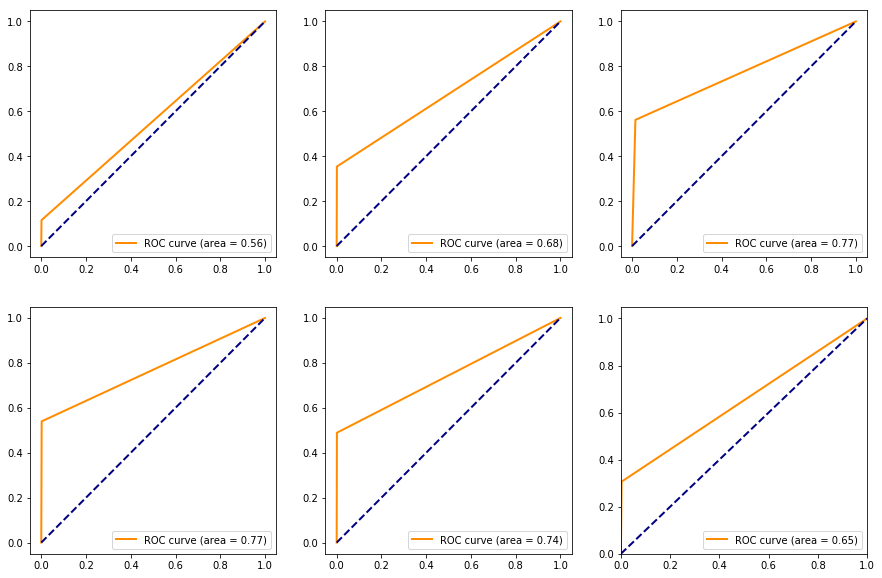

In [24]:
y_scores = [y_score_logistic,y_score_random_forest,y_score_decision_tree,y_score_gradient_boosting,y_score_XGB,y_score_Cat]
f, axs = plt.subplots(2, 3,figsize=(15,10))
for y_score,ax in zip(y_scores,np.hstack(axs)):
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score) ###计算真正率和假正率

    roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ax.legend(loc="lower right",prop={'size': 10})
plt.show()